# Before vs after normalization comparison

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn import svm

## 1. Evaluation function

In [2]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    ## Train the model and evaluate its performance
    model.fit(X_train, y_train)
    ## Make predictions on the training and test sets
    y_pred = model.predict(X_test)

    y_test = np.ravel(y_test)
    y_pred = np.ravel(y_pred)
    
    ## Calculate the RMSE and R^2 score
    results = {
        'RMSE': sqrt(mean_squared_error(y_test, y_pred)),
        'r2_score': r2_score(y_test, y_pred)
    }
    
    return results


In [3]:
## Dictionary met models en parameters
models = {
    'Linear Regression': LinearRegression(),
    'SVM (linear kernel)': svm.SVR(kernel='linear'),
    'KNR (k=2)': KNeighborsRegressor(n_neighbors=2),
    'Decision Tree': DecisionTreeRegressor()
}

## 2. Load dataset

In [4]:
df = pd.DataFrame(pd.read_csv('./mpg.csv'))

In [5]:
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    398 non-null    object 
 4   weight        398 non-null    int64  
 5   acceleration  398 non-null    float64
 6   model_year    398 non-null    int64  
 7   origin        398 non-null    int64  
 8   name          398 non-null    object 
dtypes: float64(3), int64(4), object(2)
memory usage: 28.1+ KB


In [ ]:
## Data preprocessing
## Missing values horsepower
mode_value = df.horsepower.mode()[0]
df.horsepower = df.horsepower.replace('?', mode_value)
df.horsepower = df.horsepower.astype('int64')

## Dummy columns
df.origin.value_counts()
dummies = pd.get_dummies(df.origin, prefix='origin')
df = pd.concat([df, dummies], axis=1)

## Drop columns
df = df.drop(columns=['origin'])
df = df.drop(columns=['name'])

In [8]:
X = df.iloc[:, 1:]
y = df.mpg

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle= True, random_state=42)

## 4. Normalize data

In [10]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 5. Evaluate models on both unscaled and scaled data

In [11]:
results_before = {}
results_after = {}

for name, model in models.items():
    results_before[name] = evaluate_model(model, X_train, X_test, y_train, y_test)


In [12]:
for name, model in models.items():
    results_after[name] = evaluate_model(model, X_train_scaled, X_test_scaled, y_train, y_test)

In [13]:
## dataframe met resultaten voor scaling transponeren en scaled column toevoegen
df_before = pd.DataFrame(results_before).T
df_before['scaled'] = False

## dataframe met resultaten na scaling transponeren en scaled column toevoegen
df_after = pd.DataFrame(results_after).T
df_after['scaled'] = True

# Merge into one DataFrame
df_comparison = pd.concat([df_before, df_after])

# Reorder columns
df_comparison = df_comparison[['scaled', 'RMSE', 'r2_score']]

df_comparison

,scaled,RMSE,r2_score
Linear Regression,False,2.889298,0.844735
SVM (linear kernel),False,4.782551,0.574590
KNR (k=2),False,3.978002,0.705681
Decision Tree,False,3.478811,0.774913
Linear Regression,True,2.889298,0.844735
SVM (linear kernel),True,2.884815,0.845217
KNR (k=2),True,2.358403,0.896551
Decision Tree,True,3.455033,0.777980


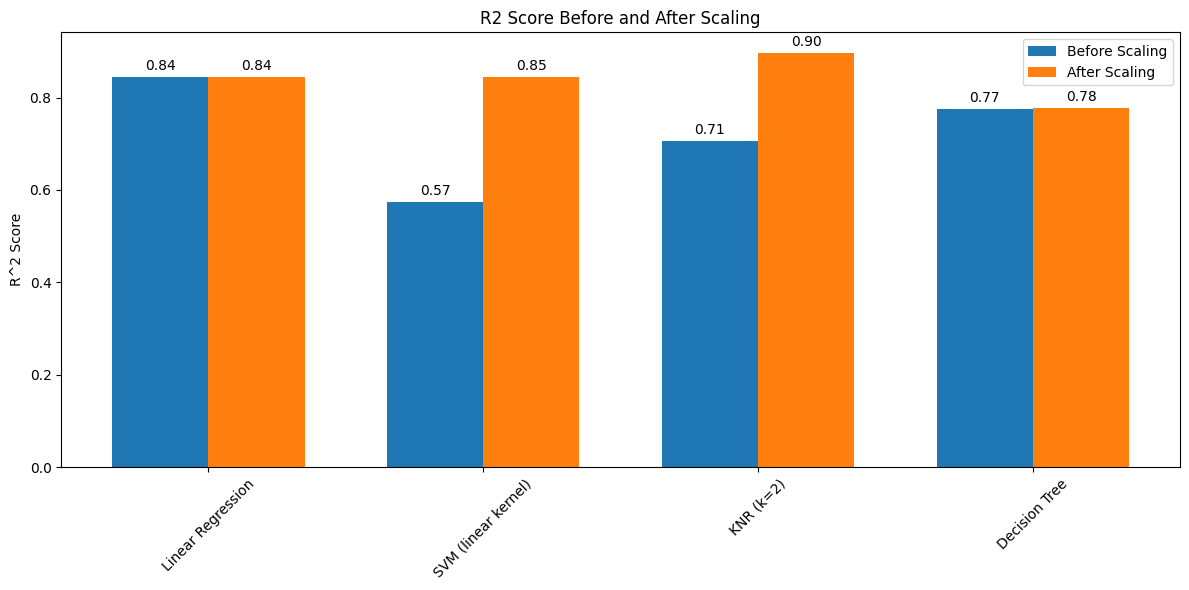

In [14]:
# Select the unique model names
model_names = ['Linear Regression', 'SVM (linear kernel)', 'KNR (k=2)', 'Decision Tree']

# Positions for each group
x = np.arange(len(model_names))
width = 0.35

# Extract values
r2_before = [results_before[model]['r2_score'] for model in model_names]
r2_after = [results_after[model]['r2_score'] for model in model_names]

# Create the plot
fig, ax = plt.subplots(figsize=(12,6))

rects1 = ax.bar(x - width/2, r2_before, width, label='Before Scaling')
rects2 = ax.bar(x + width/2, r2_after, width, label='After Scaling')

# Labels
ax.set_ylabel('R^2 Score')
ax.set_title('R2 Score Before and After Scaling')
ax.set_xticks(x)
ax.set_xticklabels(model_names, rotation=45)
ax.legend()

# Annotate
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width()/2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()